### Permutation test to see if top 10% of local identity bins per chromosome have an elevated mutation rate compared to the rest of the array

In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

#### Prepare data tables

- list of pairwise comparisons < 0.2 for each chrom 
- SNV raw mutation files for pairs < 0.2 
- top 10% local identity bins locations per sample

In [3]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df=all_pairs_dist_df[all_pairs_dist_df["direct_pairwise_dist"]< 0.2]

all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr,sample_pair
46,HG00741.2,HG01167.2,0.003675,chr6,HG00741.2_HG01167.2
984,NA19700.1,NA19835.1,0.079636,chr6,NA19700.1_NA19835.1
1224,HG02083.2,HG02129.2,0.176519,chr6,HG02083.2_HG02129.2
2003,HG02280.1,NA18879.1,0.134344,chr6,HG02280.1_NA18879.1
2046,HG02258.1,HG03583.2,0.105130,chr6,HG02258.1_HG03583.2


##### Read in SNV dataframe from CDR_mutation_permutation

In [3]:
SNVs_raw_df=pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/SNVs_raw_df.parquet")

In [17]:
SNVs_raw_df.head()

,ref_contig,ref_start,ref_end,query_contig,query_start,query_end,sample1,sample2,sample_pair,chr
0,HG00673#2#CM089162.1,50983877,50983878,HG02074#1#CM088274.1,50935171,50935172,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
1,HG00673#2#CM089162.1,50990315,50990316,HG02074#1#CM088274.1,50941609,50941610,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
2,HG00673#2#CM089162.1,50990316,50990317,HG02074#1#CM088274.1,50941610,50941611,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
3,HG00673#2#CM089162.1,50991378,50991379,HG02074#1#CM088274.1,50942672,50942673,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
4,HG00673#2#CM089162.1,50991379,50991380,HG02074#1#CM088274.1,50942673,50942674,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11


In [4]:
import pandas as pd
from pathlib import Path

ASAT_DIR = Path(
    "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/per_smp_asat_beds"
)

dfs = []

for bed_file in ASAT_DIR.glob("*_asat_arrays.bed"):
    sample = bed_file.name.replace("_asat_arrays.bed", "")

    df = pd.read_csv(
        bed_file,
        sep="\t",
        header=None,
        names=["contig", "start", "end", "chr"]
    )

    df["sample"] = sample
    dfs.append(df)

asat_df = pd.concat(dfs, ignore_index=True)

##### Get top 10% of local identity bins for each sample

In [5]:
import pandas as pd
from pathlib import Path

base_dir = Path(
    "/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/local_id_beds_asm_coords"
)

dfs = []

for chr_dir in base_dir.iterdir():
    if not chr_dir.is_dir():
        continue

    chr_name = chr_dir.name

    for bed_file in chr_dir.glob("*_local_id_asat_coords.bed"):
        # example filename: HG02647.1_chr1_local_id_asat_coords.bed
        sample = bed_file.name.split("_")[0]

        df = pd.read_csv(
            bed_file,
            sep="\t",
            header=None,
            usecols=[0, 1, 2, 4],
            names=["contig", "start", "end", "local_id"],
        )

        df["sample"] = sample
        df["chr"] = chr_name

        dfs.append(df)

# combined dataframe
local_id_df = pd.concat(dfs, ignore_index=True)
local_id_df.head()

,contig,start,end,local_id,sample,chr
0,HG02559#2#CM088251.1,50923163,50928162,96.01,HG02559.2,chr11
1,HG02559#2#CM088251.1,50928163,50933162,96.05,HG02559.2,chr11
2,HG02559#2#CM088251.1,50933163,50938162,95.78,HG02559.2,chr11
3,HG02559#2#CM088251.1,50938163,50943162,96.72,HG02559.2,chr11
4,HG02559#2#CM088251.1,50943163,50948162,97.82,HG02559.2,chr11


In [6]:
thresholds = (
    local_id_df
    .groupby(["sample", "chr"])["local_id"]
    .quantile(0.9)
    .rename("threshold")
)

top10_df = (
    local_id_df
    .join(thresholds, on=["sample", "chr"])
    .query("local_id >= threshold")
    .drop(columns="threshold")
)

top10_df.head()

,contig,start,end,local_id,sample,chr
61,HG02559#2#CM088251.1,51228163,51233162,99.54,HG02559.2,chr11
62,HG02559#2#CM088251.1,51233163,51238162,99.57,HG02559.2,chr11
63,HG02559#2#CM088251.1,51238163,51243162,99.72,HG02559.2,chr11
64,HG02559#2#CM088251.1,51243163,51248162,99.44,HG02559.2,chr11
65,HG02559#2#CM088251.1,51248163,51253162,99.60,HG02559.2,chr11


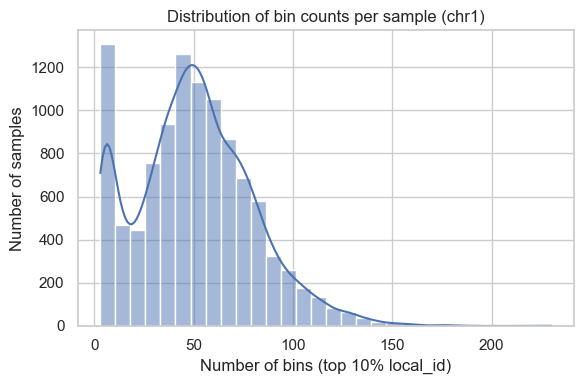

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = (
    top10_df
    .groupby(["sample", "chr"])
    .size()
    .reset_index(name="n_bins")
)


sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.histplot(
    data=counts,
    x="n_bins",
    bins=30,
    kde=True
)

plt.xlabel("Number of bins (top 10% local_id)")
plt.ylabel("Number of samples")
plt.title("Distribution of bin counts per sample (chr1)")
plt.tight_layout()
plt.show()


In [22]:
counts = (
    top10_df
    .groupby(["sample", "chr"])
    .size()
    .reset_index(name="n_bins")
)

# row(s) with the lowest number of bins
min_bins = counts["n_bins"].min()

lowest = counts[counts["n_bins"] == min_bins]

print(lowest)


          sample    chr  n_bins
8      HG00097.1  chr17       3
39     HG00097.2   chr4       3
65     HG00099.1   chr7       3
223    HG00133.2   chr6       3
234    HG00140.1  chr15       3
...          ...    ...     ...
10513  NA21110.2  chr18       3
10543  NA21144.1   chr4       3
10598  NA21309.2  chr11       3
10604  NA21309.2  chr17       3
10617  NA21309.2   chr9       3

[250 rows x 3 columns]


### Helper functions 

#### Cigar parsing for SNV aligned bases 

In [7]:
import re

def parse_cigar(cigar):
    """
    Parse a CIGAR string into a list of (length, operation) tuples.

    Example:
        '10M2I5M3D8M' ->
        [(10,'M'), (2,'I'), (5,'M'), (3,'D'), (8,'M')]
    """
    return [
        (int(length), op)
        for length, op in re.findall(r'(\d+)([MIDNSHP=X])', cigar)
    ]

def reverse_cigar(parsed):
    """
    Convert a parsed CIGAR from ref->query into query->ref.

    Insertions become deletions and vice versa.
    Matches, mismatches, and equals stay the same.
    """
    converted = []
    for length, op in parsed:
        if op == "I":
            converted.append((length, "D"))
        elif op == "D":
            converted.append((length, "I"))
        else:
            converted.append((length, op))
    return converted

def build_aligned_intervals_from_ops(cigar_ops, start_pos):
    """
    Build aligned intervals on the genome from parsed CIGAR ops.

    Parameters
    ----------
    cigar_ops : list of (length, op)
        Parsed CIGAR string
    start_pos : int
        Genomic start position of the alignment

    Returns
    -------
    intervals : list of (start, end)
        Genomic intervals where bases are aligned (M, =, X)
    """
    intervals = []
    pos = start_pos

    for length, op in cigar_ops:
        if op in ("M", "=", "X"):
            # Aligned bases
            intervals.append((pos, pos + length))
            pos += length
        elif op in ("D", "N"):
            # Consumes reference but not query
            pos += length
        # Insertions do not consume reference positions

    return intervals

#### Computing overlaps

In [8]:
def aligned_bp(aligned_intervals, query_intervals):
    """
    Compute total aligned bases overlapping query intervals.

    Both aligned_intervals and query_intervals must be:
      - sorted
      - half-open intervals [start, end)

    Uses a two-pointer sweep (O(n + m)).

    Parameters
    ----------
    aligned_intervals : list of (start, end)
        Fixed alignment blocks from CIGAR
    query_intervals : list of (start, end)
        Arbitrary windows (real or fake CDRs, ASAT)

    Returns
    -------
    total_aligned_bp : int
    """
    total = 0
    i = j = 0

    while i < len(aligned_intervals) and j < len(query_intervals):
        a_start, a_end = aligned_intervals[i]
        q_start, q_end = query_intervals[j]

        overlap = min(a_end, q_end) - max(a_start, q_start)
        if overlap > 0:
            total += overlap

        # Advance the interval that ends first
        if a_end < q_end:
            i += 1
        else:
            j += 1

    return total

import numpy as np

def count_snvs_in_intervals(snv_positions, intervals):
    """
    Count SNVs falling inside a list of intervals.

    Parameters
    ----------
    snv_positions : 1D numpy array
        Sorted SNV positions for (sample, chr, sample_pair)
    intervals : list of (start, end)

    Returns
    -------
    n_snvs : int
    """
    total = 0
    for start, end in intervals:
        total += (
            np.searchsorted(snv_positions, end, side="left")
            - np.searchsorted(snv_positions, start, side="left")
        )
    return total

def intervals_overlap(a, b):
    return not (a[1] <= b[0] or a[0] >= b[1])


def random_intervals_like(real_intervals, bounds, rng, max_tries=1000, sample_info=None):
    """
    Sample non-overlapping fake intervals matching the lengths of real_intervals,
    within bounds. Overlaps with real CDRs are allowed, but intervals within
    the same rep do not overlap each other.

    Parameters
    ----------
    sample_info : str, optional
        Info about the sample/pair to include in error messages for debugging.
    """
    fake_intervals = []
    lengths = [end - start for start, end in real_intervals]

    for L in lengths:
        start_min = bounds[0]
        start_max = bounds[1] - L
        if start_max < start_min:
            msg = f"CDR length {L} exceeds ASAT bounds {bounds}"
            if sample_info:
                msg += f" for sample/pair {sample_info}, real CDRs: {real_intervals}"
            raise ValueError(msg)

        for _ in range(max_tries):
            s = rng.integers(start_min, start_max + 1)
            candidate = (s, s + L)

            # only reject if overlaps previously placed fake CDRs
            if any(intervals_overlap(candidate, x) for x in fake_intervals):
                continue

            fake_intervals.append(candidate)
            break
        else:
            msg = f"Failed to place non-overlapping fake CDRs after {max_tries} tries"
            if sample_info:
                msg += f" for sample/pair {sample_info}, real CDRs: {real_intervals}, bounds: {bounds}"
            raise RuntimeError(msg)

    return sorted(fake_intervals)

def snv_rate( snv_positions, aligned_intervals, query_intervals):
    """
    Compute SNV rate = (# SNVs) / (aligned bases)
    for arbitrary query intervals.

    Returns NaN if aligned bases == 0.
    """
    aligned = aligned_bp(aligned_intervals, query_intervals)
    if aligned == 0:
        return np.nan

    n_snvs = count_snvs_in_intervals(snv_positions, query_intervals)
    return n_snvs / aligned

def complement_intervals(intervals, bounds):
    """
    Compute complement of intervals within given bounds.

    Parameters
    ----------
    intervals : list of (start, end)
        Intervals to exclude (e.g. CDRs)
    bounds : (start, end)
        ASAT bounds

    Returns
    -------
    outside_intervals : list of (start, end)
    """
    outside = []
    current = bounds[0]

    for start, end in sorted(intervals):
        if start > current:
            outside.append((current, start))
        current = max(current, end)

    if current < bounds[1]:
        outside.append((current, bounds[1]))

    return outside


### Pre-Processing data into dictionaries for faster lookup in permutation loop

In [9]:
import numpy as np
import pandas as pd
from collections import defaultdict

# ---------------------------------------------
# 1. pairs_df
# ---------------------------------------------
pairs_df = all_pairs_dist_df[["sample1","sample2","sample_pair","chr"]].copy()

# ---------------------------------------------
# 2. real_cdr_intervals[(sample, chr)] -> list of (start,end)
# ---------------------------------------------
real_local_id_intervals = defaultdict(list)

for row in top10_df.itertuples(index=False):
    contig, start, end, local_id, sample, chr = row
    key = (sample, chr)
    real_local_id_intervals[key].append((start, end))

# Ensure intervals are sorted
for key in real_local_id_intervals:
    real_local_id_intervals[key].sort()

# ---------------------------------------------
# 4. asat_bounds[(sample, chr)] -> (start,end)
#    Only one row per sample in asat_df
# ---------------------------------------------
asat_bounds = {}
for row in asat_df.itertuples(index=False):
    contig, start, end, chr_, sample = row
    asat_bounds[(sample, chr_)] = (start, end)

# ---------------------------------------------
# 5. snv_pos[(sample, chr, sample_pair)] -> sorted np.array
# ---------------------------------------------
snv_pos = defaultdict(list)  # intermediate dict

# SNVs_raw_df has columns:
# ref_contig, ref_start, ref_end, query_contig, query_start, query_end, sample1, sample2, sample_pair, chr
for row in SNVs_raw_df.itertuples(index=False):
    # Ref sample SNVs
    key_ref = (row.sample1, row.chr, row.sample_pair)
    snv_pos[key_ref].append(row.ref_start)

    # Query sample SNVs
    key_query = (row.sample2, row.chr, row.sample_pair)
    snv_pos[key_query].append(row.query_start)

# Convert lists to sorted np.arrays
snv_pos = {k: np.sort(np.array(v)) for k,v in snv_pos.items()}


### Build aligned intervals from cigar strings for getting aligned bases in denominator  

In [10]:
# Build contig -> start mapping per sample
contig_start_map = {}
for row in asat_df.itertuples(index=False):
    contig_start_map[(row.sample, row.contig, row.chr)] = row.start

In [11]:
### Parse cigar strings to get aligned intervals per sample pair

import pandas as pd
import os

# assumes parse_cigar, reverse_cigar, build_aligned_intervals_from_ops are already defined

aligned_intervals = {}

# Folder containing CSVs per chromosome
csv_dir = "/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR/aligned_bases_per_bed/dist_0.2_smp_contig_maps_cigars"

chroms = [f.replace(".contig_maps.csv","") 
          for f in os.listdir(csv_dir) if f.endswith(".contig_maps.csv")]

for chr_ in chroms:
    csv_path = os.path.join(csv_dir, f"{chr_}.contig_maps.csv")
    df = pd.read_csv(csv_path)

    for row in df.itertuples(index=False):
        s1, c1, s2, c2, cigar_path = row

        # skip missing files
        if not os.path.exists(cigar_path):
            print(f"Missing CIGAR file {cigar_path}, skipping {s1}-{s2}")
            continue

        # read the CIGAR string (assuming single line)
        with open(cigar_path) as f:
            cigar_string = f.readline().strip()

        # parse CIGAR
        parsed = parse_cigar(cigar_string)

        # build intervals
        ref_start = contig_start_map.get((s1, c1, chr_))
        query_start = contig_start_map.get((s2, c2, chr_))

        if ref_start is None or query_start is None:
            print(f"Missing start positions for {s1}-{c1} or {s2}-{c2}, skipping")
            continue

        ref_intervals = build_aligned_intervals_from_ops(parsed, ref_start)
        query_intervals = build_aligned_intervals_from_ops(reverse_cigar(parsed), query_start)

        # store in lookup dict
        pair_key = "_".join(sorted([s1, s2]))
        aligned_intervals[(s1, chr_, pair_key)] = ref_intervals
        aligned_intervals[(s2, chr_, pair_key)] = query_intervals


### Null distribution whole genome

In [29]:
import numpy as np

N_REPS = 1000
rng = np.random.default_rng(42)

null_distr = np.empty(N_REPS)

# Prepare one independent RNG per sample pair
pair_rngs = {}
for idx, r in enumerate(pairs_df.itertuples(index=False)):
    s1, s2, pair, chr_ = r
    # Create an RNG seeded deterministically from the global seed + index
    pair_rngs[pair] = np.random.default_rng(42 + idx)

for rep in range(N_REPS):
    print(f"Rep: {rep}")

    fake_in_rates = []
    fake_out_rates = []

    for r in pairs_df.itertuples(index=False):
    #for r in sample_pairs:
        s1, s2, pair, chr_ = r

        # skip pair if either sample has no real CDRs
        if (
            (s1, chr_) not in real_local_id_intervals
            or (s2, chr_) not in real_local_id_intervals
            or len(real_local_id_intervals[(s1, chr_)]) == 0
            or len(real_local_id_intervals[(s2, chr_)]) == 0
        ):
            continue

        for sample in (s1, s2):
            key = (sample, chr_)
            full_key = (sample, chr_, pair)

            if (
                key not in asat_bounds
                or full_key not in snv_pos
                or full_key not in aligned_intervals
            ):
                continue

            asat_start, asat_end = asat_bounds[key]
            real_cdrs = real_local_id_intervals[key]

            #print(f"Sample {sample}: read CDRs: {real_cdrs}")
            #print(f"Sample {sample}: asat coords: {asat_start},{asat_end}")

            fake_cdr = random_intervals_like(
                real_intervals=real_cdrs,
                bounds=(asat_start, asat_end),
                rng=pair_rngs[pair],
                sample_info=f"{sample}, {chr_}, {pair}"
            )

            #print(f"Sample {sample}: fake CDRs: {fake_cdr}")

            fake_outside = complement_intervals(fake_cdr, (asat_start, asat_end))

            #print(f"Sample {sample}: outside intervals: {fake_outside}")

            pos = snv_pos[full_key]
            aln = aligned_intervals[full_key]

            rate_in = snv_rate(pos, aln, fake_cdr)
            rate_out = snv_rate(pos, aln, fake_outside)

            #print(f"Sample {sample}: rate_in={rate_in}, rate_out={rate_out}")

            if np.isfinite(rate_in) and np.isfinite(rate_out):
                fake_in_rates.append(rate_in)
                fake_out_rates.append(rate_out)

    null_distr[rep] = np.mean(fake_in_rates) - np.mean(fake_out_rates)


Rep: 0
Rep: 1
Rep: 2
Rep: 3
Rep: 4
Rep: 5
Rep: 6
Rep: 7
Rep: 8
Rep: 9
Rep: 10
Rep: 11
Rep: 12
Rep: 13
Rep: 14
Rep: 15
Rep: 16
Rep: 17
Rep: 18
Rep: 19
Rep: 20
Rep: 21
Rep: 22
Rep: 23
Rep: 24
Rep: 25
Rep: 26
Rep: 27
Rep: 28
Rep: 29
Rep: 30
Rep: 31
Rep: 32
Rep: 33
Rep: 34
Rep: 35
Rep: 36
Rep: 37
Rep: 38
Rep: 39
Rep: 40
Rep: 41
Rep: 42
Rep: 43
Rep: 44
Rep: 45
Rep: 46
Rep: 47
Rep: 48
Rep: 49
Rep: 50
Rep: 51
Rep: 52
Rep: 53
Rep: 54
Rep: 55
Rep: 56
Rep: 57
Rep: 58
Rep: 59
Rep: 60
Rep: 61
Rep: 62
Rep: 63
Rep: 64
Rep: 65
Rep: 66
Rep: 67
Rep: 68
Rep: 69
Rep: 70
Rep: 71
Rep: 72
Rep: 73
Rep: 74
Rep: 75
Rep: 76
Rep: 77
Rep: 78
Rep: 79
Rep: 80
Rep: 81
Rep: 82
Rep: 83
Rep: 84
Rep: 85
Rep: 86
Rep: 87
Rep: 88
Rep: 89
Rep: 90
Rep: 91
Rep: 92
Rep: 93
Rep: 94
Rep: 95
Rep: 96
Rep: 97
Rep: 98
Rep: 99
Rep: 100
Rep: 101
Rep: 102
Rep: 103
Rep: 104
Rep: 105
Rep: 106
Rep: 107
Rep: 108
Rep: 109
Rep: 110
Rep: 111
Rep: 112
Rep: 113
Rep: 114
Rep: 115
Rep: 116
Rep: 117
Rep: 118
Rep: 119
Rep: 120
Rep: 121
Rep: 122
Rep

In [ ]:
## save null distribution out
import pandas as pd

df = pd.DataFrame({"null_statistic": null_distr})
df.to_csv("/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/020426_local_id_null_distribution.1k_reps.csv", index=False)

In [ ]:
import pandas as pd

df = pd.read_csv(
    "/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/020426_local_id_null_distribution.1k_reps.csv"
)

null_distr = df["null_statistic"].to_numpy()

### Test statistic whole genome

In [13]:
real_in_rates = []
real_out_rates = []

for r in pairs_df.itertuples(index=False):
    s1, s2, pair, chr_ = r

    # skip entire pair if either sample has no real CDRs
    if (
        (s1, chr_) not in real_local_id_intervals
        or (s2, chr_) not in real_local_id_intervals
        or len(real_local_id_intervals[(s1, chr_)]) == 0
        or len(real_local_id_intervals[(s2, chr_)]) == 0
    ):
        continue

    for sample in (s1, s2):
        key = (sample, chr_)
        full_key = (sample, chr_, pair)

        if (
            key not in asat_bounds
            or full_key not in snv_pos
            or full_key not in aligned_intervals
        ):
            continue

        cdrs = real_local_id_intervals[key]
        asat_start, asat_end = asat_bounds[key]

        outside = complement_intervals(
            cdrs,
            (asat_start, asat_end)
        )

        pos = snv_pos[full_key]
        aln = aligned_intervals[full_key]

        rate_in = snv_rate(
            snv_positions=pos,
            aligned_intervals=aln,
            query_intervals=cdrs
        )

        rate_out = snv_rate(
            snv_positions=pos,
            aligned_intervals=aln,
            query_intervals=outside
        )

        if np.isfinite(rate_in) and np.isfinite(rate_out):
            real_in_rates.append(rate_in)
            real_out_rates.append(rate_out)


In [14]:
print(real_in_rates)

[np.float64(1.3336000533440021e-05), np.float64(1.742852561644695e-05), np.float64(0.0002803675070172442), np.float64(0.00024165763327418474), np.float64(0.0013648908087353013), np.float64(0.0006589842970978678), np.float64(0.00012524100654219469), np.float64(0.0001026167265264238), np.float64(0.00021859561684560278), np.float64(0.0004633369022797428), np.float64(0.00018786917674621636), np.float64(0.00045116456854255043), np.float64(6.061818424290919e-06), np.float64(7.018947649178959e-06), np.float64(5.585578037507156e-05), np.float64(9.844323898623832e-05), np.float64(0.0003506599121111965), np.float64(0.0004300817155259499), np.float64(0.000433947058458868), np.float64(0.0005062792692702546), np.float64(0.00039428775613302284), np.float64(0.00036209503929796164), np.float64(0.00024309676681300138), np.float64(0.00020488592674725514), np.float64(0.0002651912390457937), np.float64(0.0003560910823244086), np.float64(0.00012951597003863893), np.float64(0.00010575620805998765), np.float

In [17]:
print(null_distr)

[ 5.11905117e-06  7.08325875e-06  1.19319764e-06  5.86987406e-06
 -9.49140642e-07 -2.85599282e-06  5.92698269e-06  2.94289367e-06
  4.01789971e-06  1.90609822e-06 -6.73926661e-08  3.07770615e-07
  8.35325210e-06 -4.47477343e-06  1.10473191e-05  7.21053269e-06
 -6.81845104e-06 -2.71148899e-06 -1.07733123e-06 -1.20065357e-06
 -6.93216267e-07  1.22464146e-06  7.44570650e-06  1.16736225e-06
  5.40493340e-07  1.73164198e-06  4.75347309e-06  5.48628938e-06
  5.01129521e-06  5.46466346e-06 -1.69223717e-06 -9.24583933e-06
  4.52319306e-07  7.11487499e-06  7.48189841e-06  2.34819179e-08
  1.10445439e-06 -3.20637743e-07 -4.75878292e-07  5.27825780e-06
  1.43250803e-06 -2.21293398e-07 -5.90010798e-06  7.35653930e-07
  3.51903081e-06  4.27723789e-06  6.76025045e-06  4.06722660e-06
  1.76687004e-06  5.36006627e-06  6.60107526e-06 -5.97696557e-06
  3.43848855e-07  1.15885119e-05 -3.07121703e-06  6.88730714e-07
  6.08181989e-06 -8.11540032e-07 -1.21806990e-06  5.01595815e-06
 -2.46353220e-06 -3.96984

In [18]:
print(test_stat)

-9.620050860845435e-05


In [24]:
print(test_stat)
print(null_distr.min())
print(null_distr.max())


-9.620050860845435e-05
-9.245839330246212e-06
8.872279039092584e-05


In [34]:
test_stat = np.mean(real_in_rates) - np.mean(real_out_rates)
p_value = np.mean(np.abs(null_distr) >= abs(test_stat))

if p_value == 0:
    p_value = 1 / len(null_distr)

print(p_value)

0.001


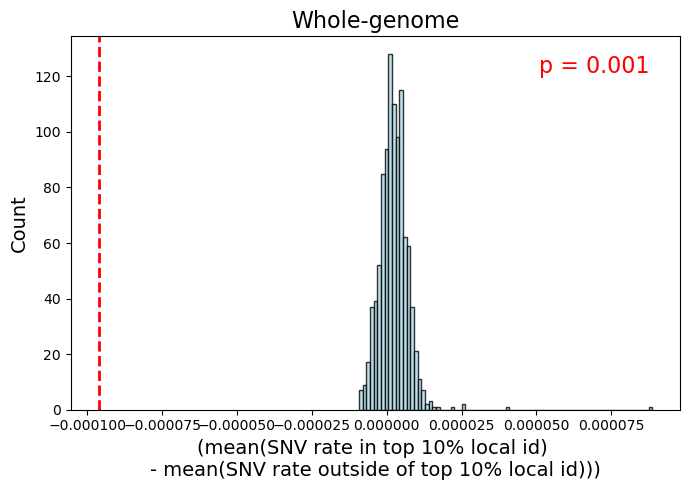

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Remove non-finite values
null_vals = null_distr[np.isfinite(null_distr)]

plt.figure(figsize=(7, 5))

# Plot null histogram
plt.hist(
    null_vals,
    bins=80,
    color='lightblue',
    edgecolor='black',
    alpha=0.8
)

# Determine colors based on p-value
if p_value < 0.01:
    line_color = 'red'
    p_text_color = 'red'
else:
    line_color = 'black'
    p_text_color = 'black'

# Plot observed test statistic
plt.axvline(
    test_stat,
    color=line_color,
    linestyle='--',
    linewidth=2
)

# Add p-value text (upper right, fixed decimal)
plt.text(
    0.95, 0.95,
    f"p = {p_value:.3f}",
    transform=plt.gca().transAxes,
    fontsize=16,
    color=p_text_color,
    ha='right',
    va='top'
)

plt.xlabel("(mean(SNV rate in top 10% local id) \n- mean(SNV rate outside of top 10% local id)))", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Whole-genome", fontsize=16)

# Increase tick sizes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)
plt.tight_layout()
plt.show()

### Per-chrom permutations

In [ ]:
import numpy as np

N_REPS = 1000

# Get all chromosomes present in the data
chromosomes = pairs_df['chr'].unique()

# Dictionary to hold null distributions per chromosome
nulls_per_chr = {}

for chr_ in chromosomes:
    print(f"Processing chromosome {chr_}")
    
    # Subset to pairs in this chromosome
    chr_pairs_df = pairs_df[pairs_df['chr'] == chr_]
    
    # Prepare one independent RNG per pair in this chromosome
    pair_rngs = {}
    for idx, r in enumerate(chr_pairs_df.itertuples(index=False)):
        s1, s2, pair, chr_tmp = r
        pair_rngs[pair] = np.random.default_rng(42 + idx)
    
    # Array to hold null distribution for this chromosome
    null_distr = np.empty(N_REPS)
    
    for rep in range(N_REPS):
        fake_in_rates = []
        fake_out_rates = []

        for r in chr_pairs_df.itertuples(index=False):
            s1, s2, pair, chr_tmp = r

            # Skip if either sample has no real CDRs
            if (
                (s1, chr_) not in real_local_id_intervals
                or (s2, chr_) not in real_local_id_intervals
                or len(real_local_id_intervals[(s1, chr_)]) == 0
                or len(real_local_id_intervals[(s2, chr_)]) == 0
            ):
                continue

            for sample in (s1, s2):
                key = (sample, chr_)
                full_key = (sample, chr_, pair)

                if (
                    key not in asat_bounds
                    or full_key not in snv_pos
                    or full_key not in aligned_intervals
                ):
                    continue

                asat_start, asat_end = asat_bounds[key]
                real_cdrs = real_local_id_intervals[key]

                fake_cdr = random_intervals_like(
                    real_intervals=real_cdrs,
                    bounds=(asat_start, asat_end),
                    rng=pair_rngs[pair],
                    sample_info=f"{sample}, {chr_}, {pair}"
                )

                fake_outside = complement_intervals(fake_cdr, (asat_start, asat_end))

                pos = snv_pos[full_key]
                aln = aligned_intervals[full_key]

                rate_in = snv_rate(pos, aln, fake_cdr)
                rate_out = snv_rate(pos, aln, fake_outside)

                if np.isfinite(rate_in) and np.isfinite(rate_out):
                    fake_in_rates.append(rate_in)
                    fake_out_rates.append(rate_out)

        # Store mean difference in null distribution
        null_distr[rep] = np.mean(fake_in_rates) - np.mean(fake_out_rates)

    # Save null distribution for this chromosome
    nulls_per_chr[chr_] = null_distr

print("Done! Null distributions per chromosome are stored in `nulls_per_chr`.")

## save null distribution out
import pandas as pd



Processing chromosome chr6
Processing chromosome chr19
Processing chromosome chr15
Processing chromosome chr17
Processing chromosome chrY
Processing chromosome chr18
Processing chromosome chr9
Processing chromosome chr11
Processing chromosome chr8
Processing chromosome chr12
Processing chromosome chrX
Processing chromosome chr3
Processing chromosome chr7
Processing chromosome chr22
Processing chromosome chr16
Processing chromosome chr4
Processing chromosome chr10
Processing chromosome chr20
Processing chromosome chr13
Processing chromosome chr21
Processing chromosome chr2
Processing chromosome chr1
Processing chromosome chr14
Processing chromosome chr5
Done! Null distributions per chromosome are stored in `nulls_per_chr`.


In [40]:
print(nulls_per_chr)

{'chr6': array([ 8.61746609e-06,  5.49222844e-06,  2.07354770e-05, -3.27703778e-05,
       -1.46495957e-05,  1.51403437e-05,  1.68781603e-05, -1.29557606e-05,
       -1.97525421e-05, -9.22221820e-06,  2.37548700e-05, -1.47930441e-05,
       -4.60313020e-06, -1.61748366e-05, -2.23286449e-05, -9.95320771e-06,
       -2.59691293e-05, -4.04286513e-06,  7.17916645e-06, -7.65103978e-06,
       -6.60903791e-06, -1.39685709e-05,  1.04970762e-05,  3.40218310e-05,
        1.06559242e-06, -8.24108730e-06, -8.37157035e-06,  7.66821365e-08,
       -1.47618687e-05, -5.69584493e-06,  1.81065074e-06, -8.56916689e-06,
       -2.19472089e-05,  1.52945964e-05,  3.79914686e-06,  7.42598541e-06,
        9.10671027e-06,  5.05296010e-05,  2.34927224e-06,  1.53860040e-05,
        3.12603354e-05, -2.64234673e-06, -1.25483109e-05,  4.84299442e-06,
        4.55044723e-06, -1.64962569e-05,  2.04755077e-05, -2.35646220e-06,
       -1.91866785e-05, -1.82262645e-05, -3.46524130e-05, -1.26097080e-05,
        2.112538

In [ ]:
import pandas as pd

null_distr_per_chrom_df = pd.DataFrame(nulls_per_chr)

null_distr_per_chrom_df.to_csv(
    "/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/020426_local_id_null_distribution_per_chr.1k_reps.csv",
    index=False
)


In [ ]:
null_distr_per_chrom_df = pd.read_csv("/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/020426_local_id_null_distribution_per_chr.1k_reps.csv")

#### Per chrom test statistic 

In [38]:
import pandas as pd
import numpy as np

# Prepare a list to store results
results = []

# Loop over chromosomes
for chrom in pairs_df['chr'].unique():
    print(f"Processing chromosome {chrom}")

    # Subset pairs_df to this chromosome
    chr_pairs_df = pairs_df[pairs_df['chr'] == chrom]

    # Lists to store per-pair rates
    real_in_rates = []
    real_out_rates = []

    # Loop over pairs
    for r in chr_pairs_df.itertuples(index=False):
        s1, s2, pair, chr_ = r
        # Skip pairs if either sample has no real CDRs
        if (
            (s1, chr_) not in real_local_id_intervals
            or (s2, chr_) not in real_local_id_intervals
            or len(real_local_id_intervals[(s1, chr_)]) == 0
            or len(real_local_id_intervals[(s2, chr_)]) == 0
        ):
            continue

        for sample in (s1, s2):
            key = (sample, chr_)
            full_key = (sample, chr_, pair)

            # Skip if missing required data
            if (
                key not in asat_bounds
                or full_key not in snv_pos
                or full_key not in aligned_intervals
            ):
                continue

            # Get real CDRs and ASAT bounds
            cdrs = real_local_id_intervals[key]
            asat_start, asat_end = asat_bounds[key]

            # Compute complement intervals
            outside = complement_intervals(cdrs, (asat_start, asat_end))

            pos = snv_pos[full_key]
            aln = aligned_intervals[full_key]

            # Compute SNV rates
            rate_in = snv_rate(pos, aln, cdrs)
            rate_out = snv_rate(pos, aln, outside)

            # Only keep finite values
            if np.isfinite(rate_in) and np.isfinite(rate_out):
                real_in_rates.append(rate_in)
                real_out_rates.append(rate_out)

    # Compute test statistic for this chromosome
    if len(real_in_rates) > 0 and len(real_out_rates) > 0:
        test_stat = np.mean(real_in_rates) - np.mean(real_out_rates)
    else:
        test_stat = np.nan  # if no valid pairs

    # Store result
    results.append({
        "chr": chrom,
        "n_pairs": len(chr_pairs_df),
        "n_rates": len(real_in_rates),  # number of SNV rates included
        "mean_in_rate": np.mean(real_in_rates) if real_in_rates else np.nan,
        "mean_out_rate": np.mean(real_out_rates) if real_out_rates else np.nan,
        "test_stat": test_stat
    })

# Convert to DataFrame
per_chrom_results_df = pd.DataFrame(results)

print(per_chrom_results_df)


Processing chromosome chr6
Processing chromosome chr19
Processing chromosome chr15
Processing chromosome chr17
Processing chromosome chrY
Processing chromosome chr18
Processing chromosome chr9
Processing chromosome chr11
Processing chromosome chr8
Processing chromosome chr12
Processing chromosome chrX
Processing chromosome chr3
Processing chromosome chr7
Processing chromosome chr22
Processing chromosome chr16
Processing chromosome chr4
Processing chromosome chr10
Processing chromosome chr20
Processing chromosome chr13
Processing chromosome chr21
Processing chromosome chr2
Processing chromosome chr1
Processing chromosome chr14
Processing chromosome chr5
      chr  n_pairs  n_rates  mean_in_rate  mean_out_rate  test_stat
0    chr6       33       66      0.000300       0.000412  -0.000112
1   chr19      235      460      0.001161       0.001196  -0.000034
2   chr15       99      198      0.000341       0.000563  -0.000222
3   chr17       22       42      0.000400       0.000615  -0.000215

In [46]:
import pandas as pd
import numpy as np

# Copy the results df to add p-values
per_chrom_results_df = per_chrom_results_df.copy()
per_chrom_results_df["p_value"] = np.nan

# Loop over chromosomes
for chrom in per_chrom_results_df["chr"]:
    # Real test statistic
    test_stat = per_chrom_results_df.loc[per_chrom_results_df["chr"] == chrom, "test_stat"].values[0]

    # Null distribution for this chromosome
    # Extract NumPy array for this chromosome
    null_distr = null_distr_per_chrom_df[chrom].values

    # Compute p-value: fraction of null >= observed test statistic
    # For two-tailed: np.mean(np.abs(null_distr) >= abs(test_stat))
    p_value = np.mean(np.abs(null_distr) >= abs(test_stat))

    if p_value == 0:
        p_value = 1 / len(null_distr)

    # Store
    per_chrom_results_df.loc[per_chrom_results_df["chr"] == chrom, "p_value"] = p_value

for _, row in per_chrom_results_df.iterrows():
    chrom = row['chr']
    test_stat = row['test_stat']
    p_value = row['p_value']

    # Format p-value
    if p_value < 1e-5:
        p_str = f"{p_value:.2e}"   # scientific notation with 2 decimals
    else:
        p_str = f"{p_value:.6f}"   # fixed point, 6 decimals

    print(f"{chrom}  test_stat: {test_stat:.6f}  p_value: {p_str}")

chr6  test_stat: -0.000112  p_value: 0.001000
chr19  test_stat: -0.000034  p_value: 0.070000
chr15  test_stat: -0.000222  p_value: 0.001000
chr17  test_stat: -0.000215  p_value: 0.001000
chrY  test_stat: -0.000115  p_value: 0.447000
chr18  test_stat: -0.000066  p_value: 0.040000
chr9  test_stat: -0.000211  p_value: 0.001000
chr11  test_stat: 0.000067  p_value: 0.001000
chr8  test_stat: -0.000092  p_value: 0.001000
chr12  test_stat: -0.000250  p_value: 0.001000
chrX  test_stat: -0.000108  p_value: 0.001000
chr3  test_stat: -0.000294  p_value: 0.001000
chr7  test_stat: -0.000046  p_value: 0.001000
chr22  test_stat: -0.000111  p_value: 0.001000
chr16  test_stat: -0.000153  p_value: 0.001000
chr4  test_stat: -0.000292  p_value: 0.019000
chr10  test_stat: -0.000237  p_value: 0.001000
chr20  test_stat: -0.000159  p_value: 0.001000
chr13  test_stat: -0.000091  p_value: 0.001000
chr21  test_stat: -0.000063  p_value: 0.231000
chr2  test_stat: 0.000037  p_value: 0.045000
chr1  test_stat: -0.0000

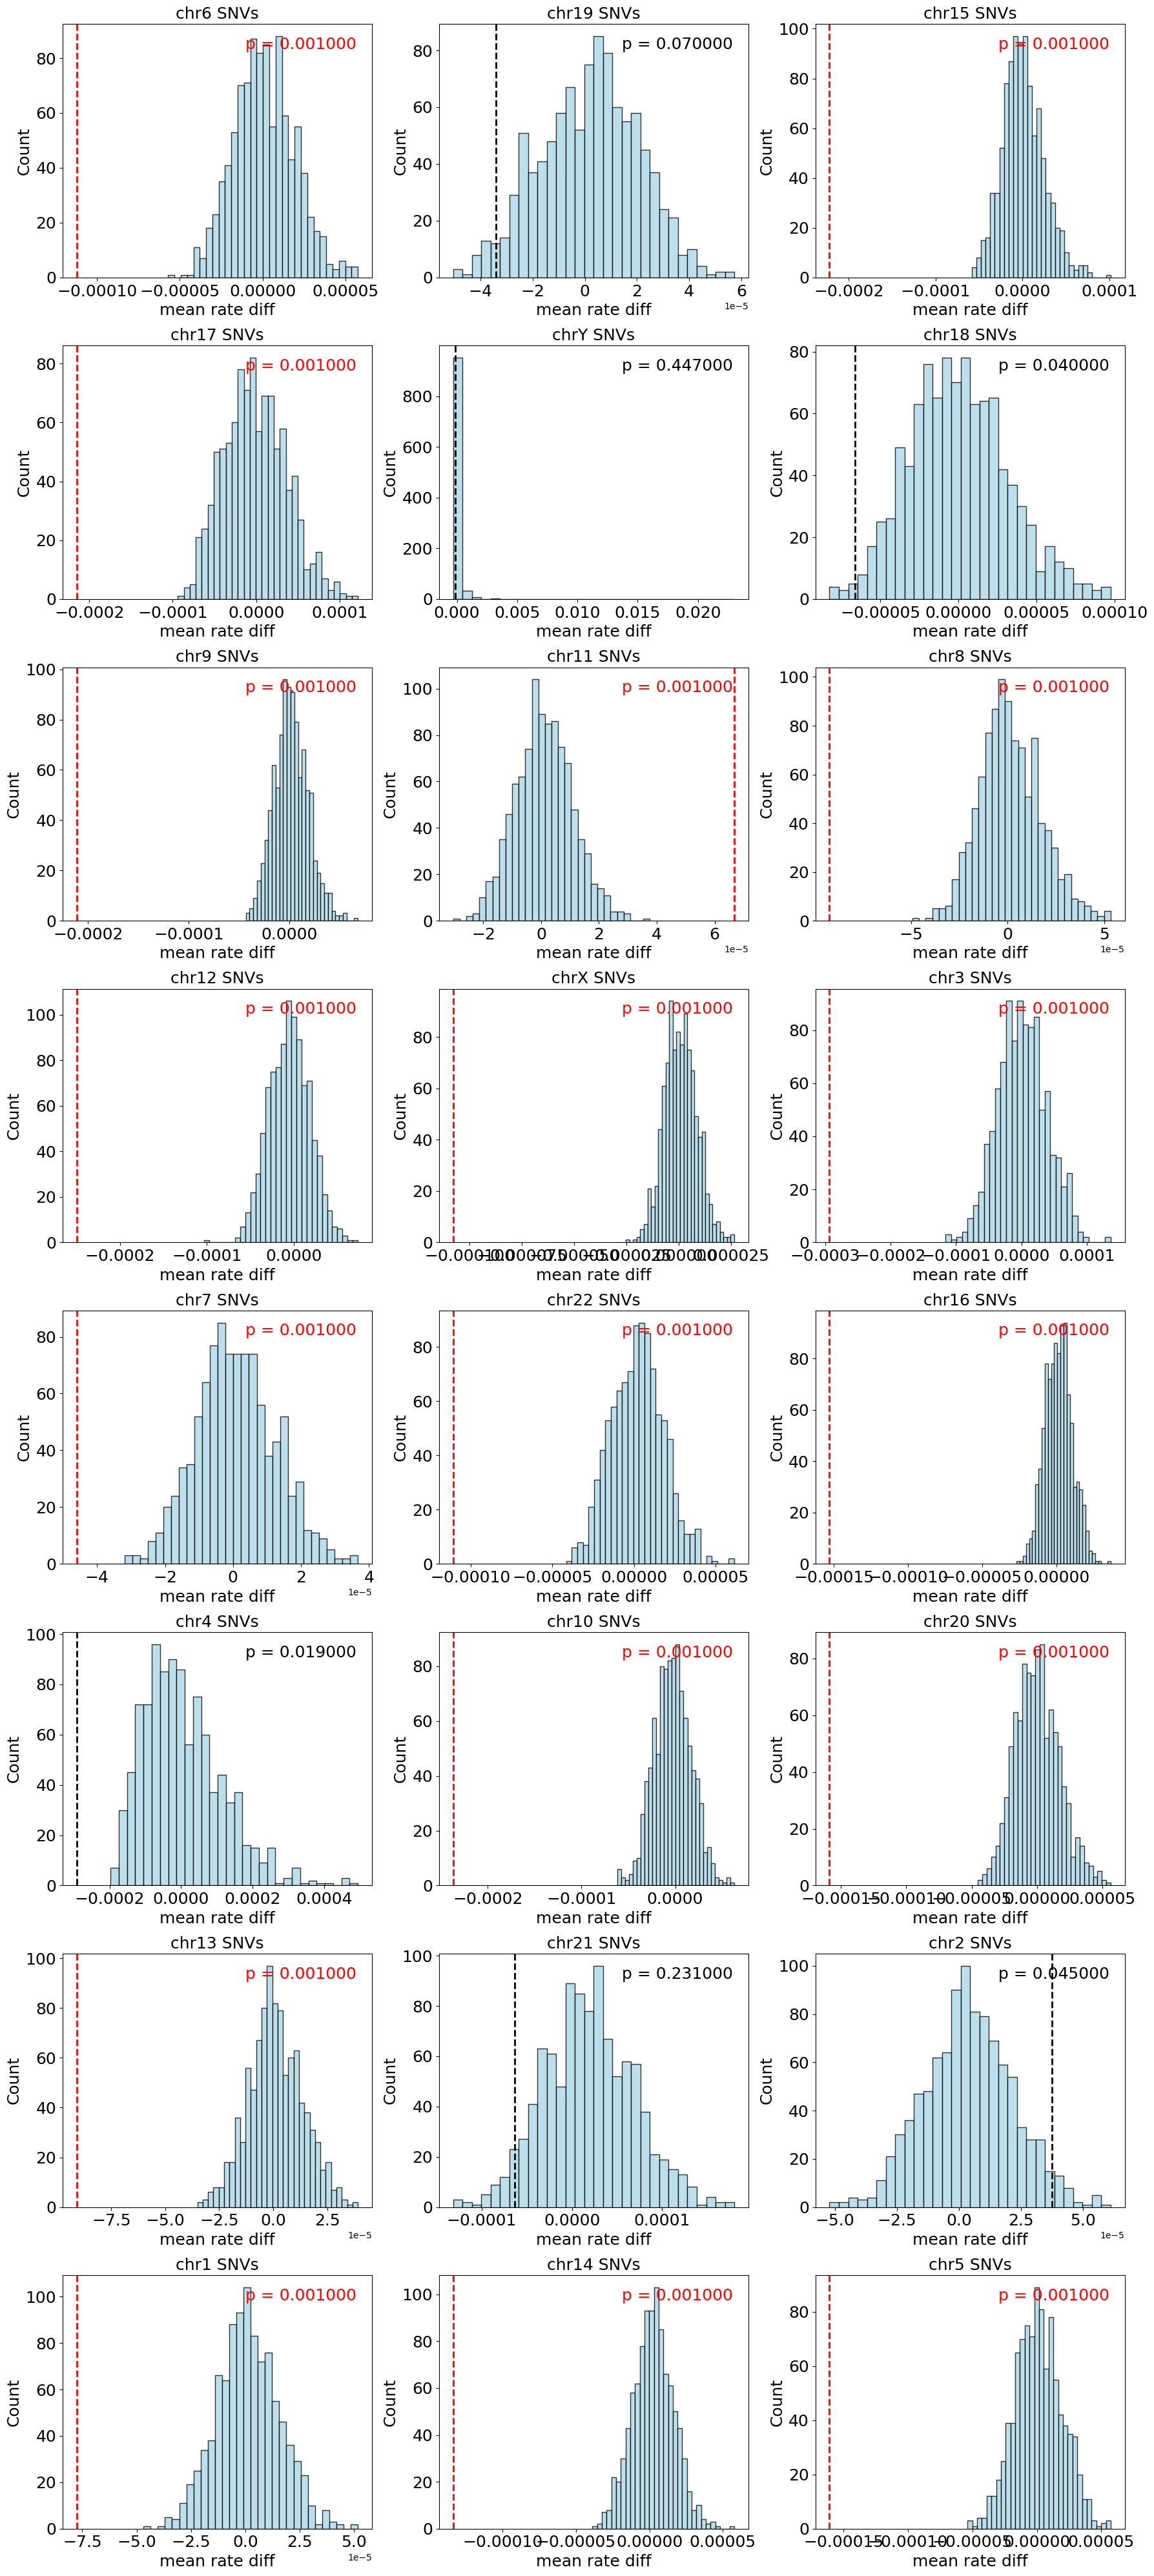

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Get chromosomes and layout
chromosomes = per_chrom_results_df['chr'].tolist()
n_chroms = len(chromosomes)
cols = 3
rows = int(np.ceil(n_chroms / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5), squeeze=False)

for idx, chrom in enumerate(chromosomes):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]
    
    # Null distribution and test stat
    null_vals = null_distr_per_chrom_df[chrom].values
    test_stat = per_chrom_results_df.loc[
        per_chrom_results_df['chr'] == chrom, 'test_stat'
    ].values[0]
    p_val = per_chrom_results_df.loc[
        per_chrom_results_df['chr'] == chrom, 'p_value'
    ].values[0]
    
    # Plot null histogram
    ax.hist(
        null_vals,
        bins=30,
        color='lightblue',
        edgecolor='black',
        alpha=0.8
    )
    
    # Color based on significance
    if p_val < 0.01:
        line_color = 'red'
        p_text_color = 'red'
    else:
        line_color = 'black'
        p_text_color = 'black'
    
    # Format p-value text
    if p_val < 1e-5:
        p_text = f"p = {p_val:.2e}"
    else:
        p_text = f"p = {p_val:.6f}"
    
    # Plot observed test statistic
    ax.axvline(test_stat, color=line_color, linestyle='--', linewidth=2)
    
    # Add p-value text
    ax.text(
        0.95, 0.95,
        p_text,
        transform=ax.transAxes,
        fontsize=18,
        color=p_text_color,
        ha='right',
        va='top'
    )
    
    ax.set_title(f"{chrom} SNVs", fontsize=18)
    ax.set_xlabel("mean rate diff", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)

    # Tick sizes
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    ax.grid(False)

# Hide empty subplots
for idx in range(n_chroms, rows * cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


### SNVs with 10k reps

In [1]:
null_per_chr_SNVs_10k="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps/local_id_null_distribution_per_chr.csv"
test_stat_per_chr_SNVs="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps/local_id_per_chrom_results.csv"

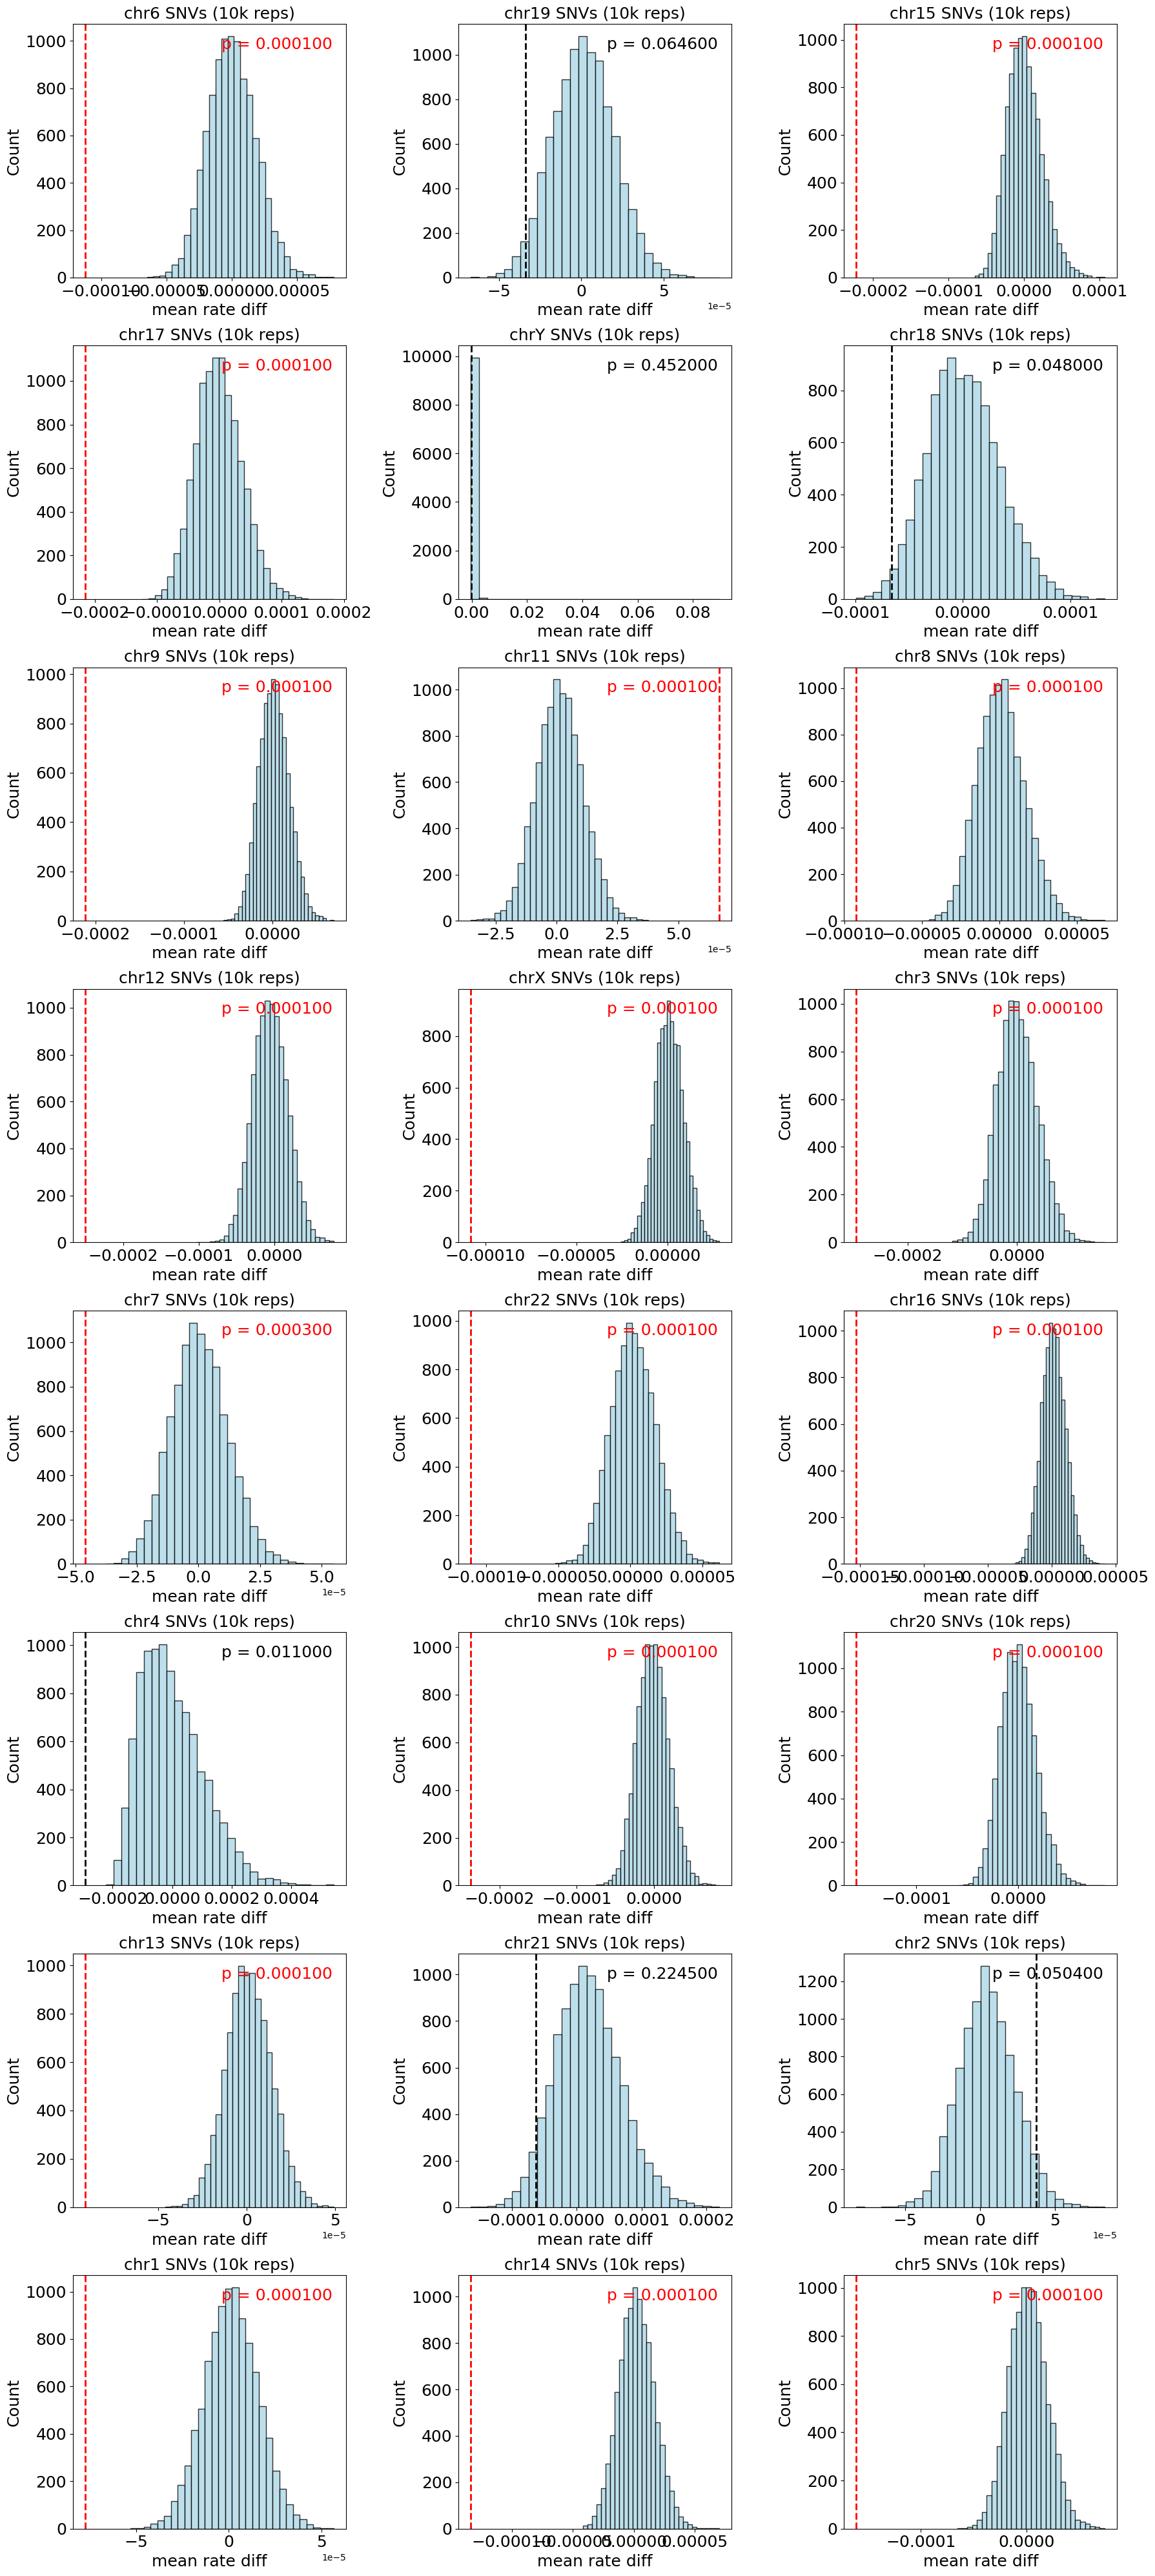

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read 10k rep results
null_10k_df = pd.read_csv(null_per_chr_SNVs_10k)
test_stat_10k_df = pd.read_csv(test_stat_per_chr_SNVs)

# Get chromosomes and layout
chromosomes = test_stat_10k_df['chr'].tolist()
n_chroms = len(chromosomes)
cols = 3
rows = int(np.ceil(n_chroms / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5), squeeze=False)

for idx, chrom in enumerate(chromosomes):
    row_idx = idx // cols
    col_idx = idx % cols
    ax = axes[row_idx, col_idx]

    # Null distribution and test stat
    null_vals = null_10k_df[chrom].values
    test_stat = test_stat_10k_df.loc[
        test_stat_10k_df['chr'] == chrom, 'test_stat'
    ].values[0]
    p_val = test_stat_10k_df.loc[
        test_stat_10k_df['chr'] == chrom, 'p_value'
    ].values[0]

    # Plot null histogram
    ax.hist(
        null_vals,
        bins=30,
        color='lightblue',
        edgecolor='black',
        alpha=0.8
    )

    # Color based on significance
    if p_val < 0.01:
        line_color = 'red'
        p_text_color = 'red'
    else:
        line_color = 'black'
        p_text_color = 'black'

    # Format p-value text
    if p_val < 1e-5:
        p_text = f"p = {p_val:.2e}"
    else:
        p_text = f"p = {p_val:.6f}"

    # Plot observed test statistic
    ax.axvline(test_stat, color=line_color, linestyle='--', linewidth=2)

    # Add p-value text
    ax.text(
        0.95, 0.95,
        p_text,
        transform=ax.transAxes,
        fontsize=18,
        color=p_text_color,
        ha='right',
        va='top'
    )

    ax.set_title(f"{chrom} SNVs (10k reps)", fontsize=18)
    ax.set_xlabel("mean rate diff", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)

    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    ax.grid(False)

# Hide empty subplots
for idx in range(n_chroms, rows * cols):
    row_idx = idx // cols
    col_idx = idx % cols
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

#### Write out short indel df for permutation tests

In [8]:
 # Read in short indels BED files (only for pairs in all_pairs_dist_df)
indel_dir = "/private/groups/patenlab/mira/centrolign/analysis/short_indels_pairwise_asm_coords/"

# Build set of (sample_pair, chr) to keep
valid_pairs = set(zip(all_pairs_dist_df["sample_pair"], all_pairs_dist_df["chr"]))

indel_dfs = []

for chr_dir in Path(indel_dir).iterdir():
    if not chr_dir.is_dir():
        continue
    chr_val = chr_dir.name

    bed_parent = chr_dir / "short_indel_beds"
    if not bed_parent.exists():
        continue

    for subgroup_dir in bed_parent.iterdir():
        if not subgroup_dir.is_dir():
            continue

        for bed_file in subgroup_dir.glob("*.bed"):
            stem = bed_file.stem  # HG00097.1_HG00126.1
            parts = stem.split("_")
            s1, s2 = parts[0], parts[1]
            sample_pair = "_".join(sorted([s1, s2]))

            if (sample_pair, chr_val) not in valid_pairs:
                continue

            df = pd.read_csv(
                bed_file,
                sep="\t",
                header=None,
                names=["ref_contig", "ref_start", "ref_end",
                       "query_contig", "query_start", "query_end",
                       "type", "dist"],
            )
            df["sample1"] = s1
            df["sample2"] = s2
            df["sample_pair"] = sample_pair
            df["chr"] = chr_val

            indel_dfs.append(df)

indels_raw_df = pd.concat(indel_dfs, ignore_index=True)

indels_raw_df.head()

,ref_contig,ref_start,ref_end,query_contig,query_start,query_end,type,dist,sample1,sample2,sample_pair,chr
0,HG00673#2#CM089162.1,51015323,51015324,HG02074#1#CM088274.1,50957285,50957286,D,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
1,HG00673#2#CM089162.1,51101585,51101586,HG02074#1#CM088274.1,51037577,51037578,D,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
2,HG00673#2#CM089162.1,51198549,51198550,HG02074#1#CM088274.1,51137939,51137940,D,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
3,HG00673#2#CM089162.1,51228060,51228061,HG02074#1#CM088274.1,51164900,51164901,D,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
4,HG00673#2#CM089162.1,51282784,51282785,HG02074#1#CM088274.1,51213692,51213693,I,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11


In [9]:
# subset to triangles and trapezoids only 
indels_raw_df = indels_raw_df[(indels_raw_df["dist"] == -1) | (indels_raw_df["dist"] > 0.1)]

# drop type and dist columns 
indels_raw_df = indels_raw_df.drop(columns=["type", "dist"])

# write to parquet 
indels_raw_df.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/short_indels_pairwise_asm_coords/short_indels_raw_df_tri_traps_distlt0.2.parquet")

#### Plot short indels 10k reps 

In [15]:
null_per_chr_shortindels_10k="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_short_indels/local_id_indel_null_distribution_per_chr.csv"
test_stat_per_chr_shortindels="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_short_indels/local_id_indel_per_chrom_results.csv"

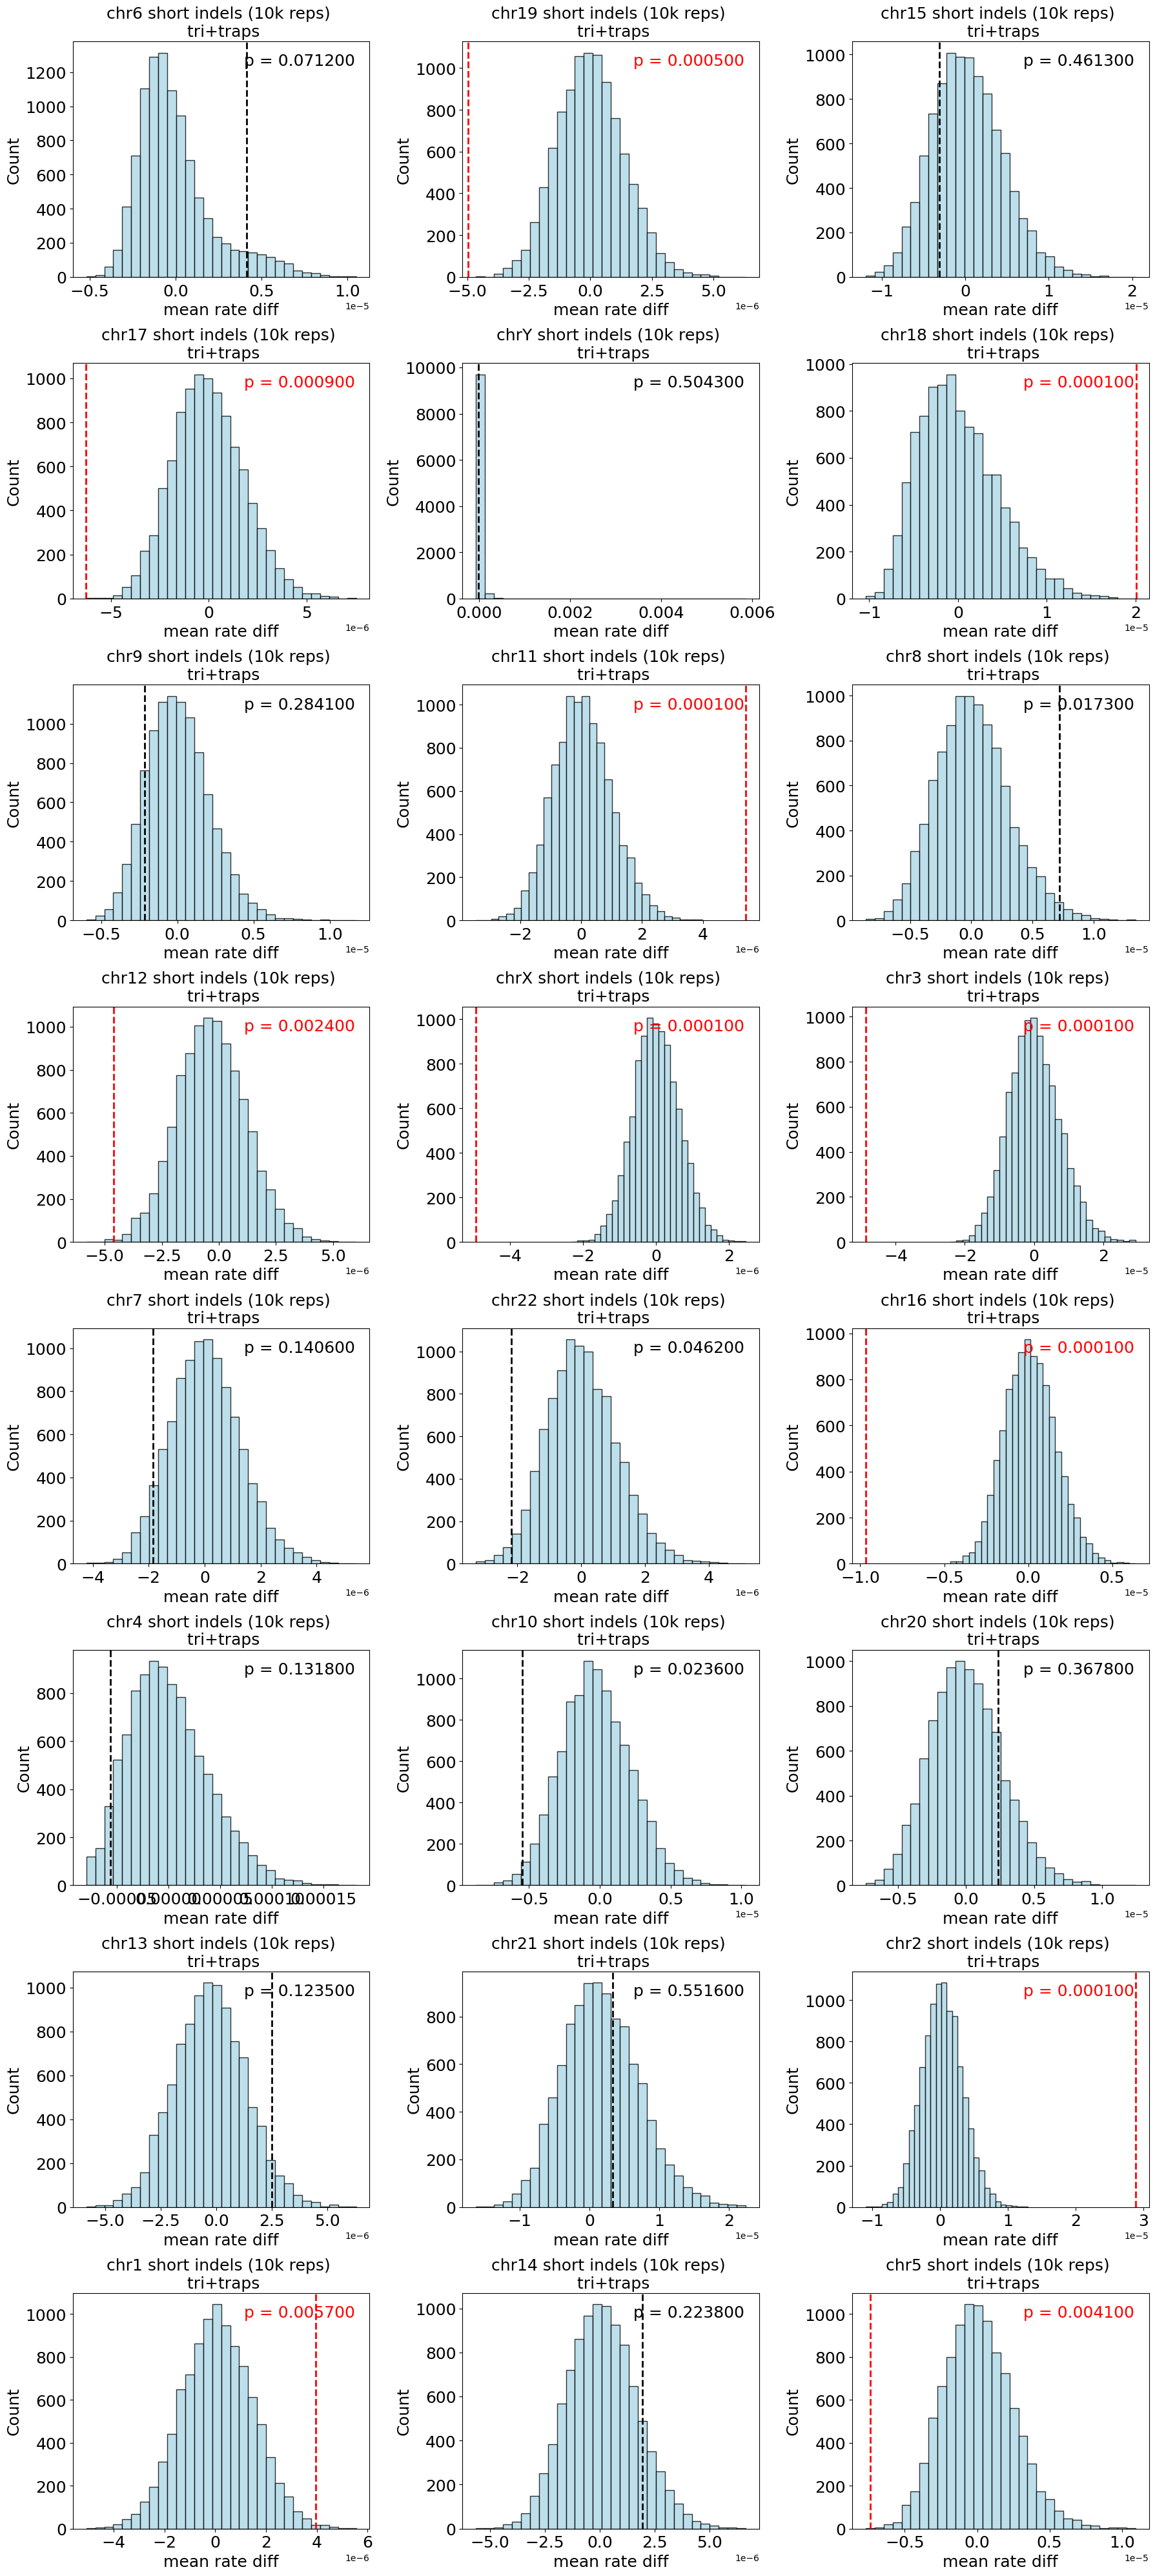

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read 10k rep results
null_10k_df = pd.read_csv(null_per_chr_shortindels_10k)
test_stat_10k_df = pd.read_csv(test_stat_per_chr_shortindels)

# Get chromosomes and layout
chromosomes = test_stat_10k_df['chr'].tolist()
n_chroms = len(chromosomes)
cols = 3
rows = int(np.ceil(n_chroms / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5), squeeze=False)

for idx, chrom in enumerate(chromosomes):
    row_idx = idx // cols
    col_idx = idx % cols
    ax = axes[row_idx, col_idx]

    # Null distribution and test stat
    null_vals = null_10k_df[chrom].values
    test_stat = test_stat_10k_df.loc[
        test_stat_10k_df['chr'] == chrom, 'test_stat'
    ].values[0]
    p_val = test_stat_10k_df.loc[
        test_stat_10k_df['chr'] == chrom, 'p_value'
    ].values[0]

    # Plot null histogram
    ax.hist(
        null_vals,
        bins=30,
        color='lightblue',
        edgecolor='black',
        alpha=0.8
    )

    # Color based on significance
    if p_val < 0.01:
        line_color = 'red'
        p_text_color = 'red'
    else:
        line_color = 'black'
        p_text_color = 'black'

    # Format p-value text
    if p_val < 1e-5:
        p_text = f"p = {p_val:.2e}"
    else:
        p_text = f"p = {p_val:.6f}"

    # Plot observed test statistic
    ax.axvline(test_stat, color=line_color, linestyle='--', linewidth=2)

    # Add p-value text
    ax.text(
        0.95, 0.95,
        p_text,
        transform=ax.transAxes,
        fontsize=18,
        color=p_text_color,
        ha='right',
        va='top'
    )

    ax.set_title(f"{chrom} short indels (10k reps) \n tri+traps", fontsize=18)
    ax.set_xlabel("mean rate diff", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)

    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    ax.grid(False)

# Hide empty subplots
for idx in range(n_chroms, rows * cols):
    row_idx = idx // cols
    col_idx = idx % cols
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

### SVs 

In [10]:
 # Read in SV BED files (only for pairs in all_pairs_dist_df)
sv_dir = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise_asm_coords/"

# Build set of (sample_pair, chr) to keep
valid_pairs = set(zip(all_pairs_dist_df["sample_pair"], all_pairs_dist_df["chr"]))

sv_dfs = []

for chr_dir in Path(sv_dir).iterdir():
    if not chr_dir.is_dir():
        continue
    chr_val = chr_dir.name

    bed_parent = chr_dir / "SV_beds"
    if not bed_parent.exists():
        continue

    for subgroup_dir in bed_parent.iterdir():
        if not subgroup_dir.is_dir():
            continue

        for bed_file in subgroup_dir.glob("*.bed"):
            stem = bed_file.stem  # HG00097.1_HG00126.1
            parts = stem.split("_")
            s1, s2 = parts[0], parts[1]
            sample_pair = "_".join(sorted([s1, s2]))

            if (sample_pair, chr_val) not in valid_pairs:
                continue

            df = pd.read_csv(
                bed_file,
                sep="\t",
                header=None,
                names=["ref_contig", "ref_start", "ref_end",
                       "query_contig", "query_start", "query_end",
                       "type", "dist"],
            )
            df["sample1"] = s1
            df["sample2"] = s2
            df["sample_pair"] = sample_pair
            df["chr"] = chr_val

            sv_dfs.append(df)

svs_raw_df = pd.concat(sv_dfs, ignore_index=True)

svs_raw_df.head()

,ref_contig,ref_start,ref_end,query_contig,query_start,query_end,type,dist,sample1,sample2,sample_pair,chr
0,HG00673#2#CM089162.1,51004845,51014177,HG02074#1#CM088274.1,50956139,50956140,D,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
1,HG00673#2#CM089162.1,51036709,51036710,HG02074#1#CM088274.1,50978670,50979520,I,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
2,HG00673#2#CM089162.1,51036732,51036733,HG02074#1#CM088274.1,50979543,50980393,I,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
3,HG00673#2#CM089162.1,51056983,51058683,HG02074#1#CM088274.1,51000644,51000645,D,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11
4,HG00673#2#CM089162.1,51068373,51069223,HG02074#1#CM088274.1,51010334,51010335,D,-1.0,HG00673.2,HG02074.1,HG00673.2_HG02074.1,chr11


In [11]:
# subset to triangles and trapezoids only 
svs_raw_df = svs_raw_df[(svs_raw_df["dist"] == -1) | (svs_raw_df["dist"] > 0.1)]

# drop type and dist columns 
svs_raw_df = svs_raw_df.drop(columns=["type", "dist"])

# write to parquet 
svs_raw_df.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise_asm_coords/svs_df_tri_traps_distlt0.2.parquet")

In [13]:
null_per_chr_svs_10k="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_svs/local_id_sv_null_distribution_per_chr.csv"
test_stat_per_chr_svs="/private/groups/patenlab/mira/centrolign/analysis/local_identity/permutation/per_chrom_results_10k_reps_svs/local_id_sv_per_chrom_results.csv"

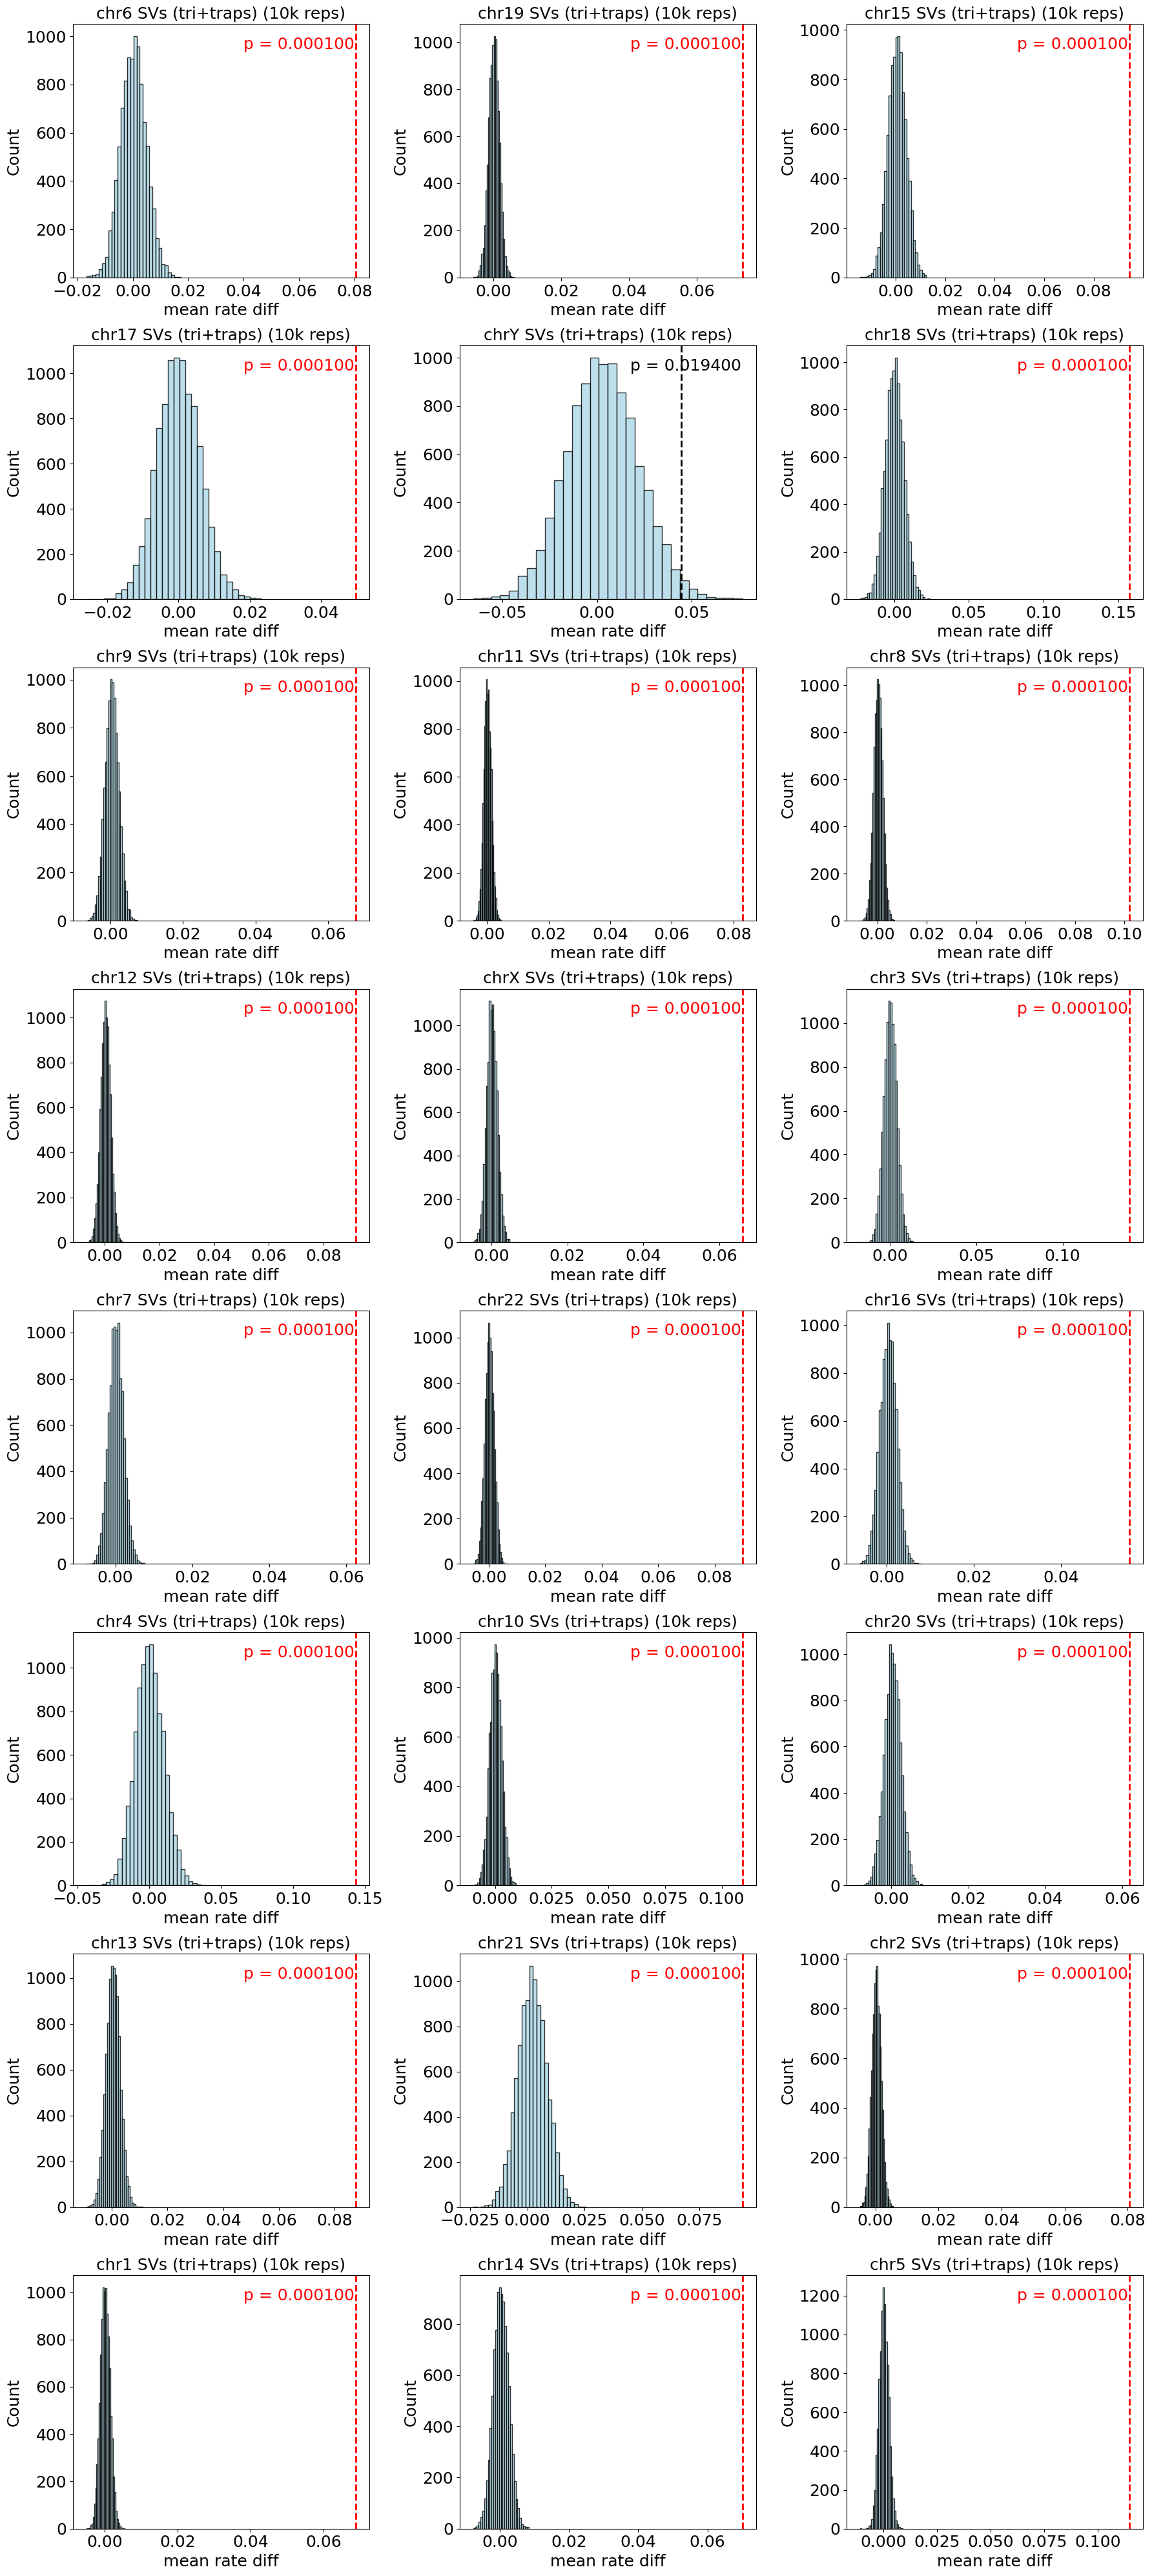

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read 10k rep results
null_10k_df = pd.read_csv(null_per_chr_svs_10k)
test_stat_10k_df = pd.read_csv(test_stat_per_chr_svs)

# Get chromosomes and layout
chromosomes = test_stat_10k_df['chr'].tolist()
n_chroms = len(chromosomes)
cols = 3
rows = int(np.ceil(n_chroms / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5), squeeze=False)

for idx, chrom in enumerate(chromosomes):
    row_idx = idx // cols
    col_idx = idx % cols
    ax = axes[row_idx, col_idx]

    # Null distribution and test stat
    null_vals = null_10k_df[chrom].values
    test_stat = test_stat_10k_df.loc[
        test_stat_10k_df['chr'] == chrom, 'test_stat'
    ].values[0]
    p_val = test_stat_10k_df.loc[
        test_stat_10k_df['chr'] == chrom, 'p_value'
    ].values[0]

    # Plot null histogram
    ax.hist(
        null_vals,
        bins=30,
        color='lightblue',
        edgecolor='black',
        alpha=0.8
    )

    # Color based on significance
    if p_val < 0.01:
        line_color = 'red'
        p_text_color = 'red'
    else:
        line_color = 'black'
        p_text_color = 'black'

    # Format p-value text
    if p_val < 1e-5:
        p_text = f"p = {p_val:.2e}"
    else:
        p_text = f"p = {p_val:.6f}"

    # Plot observed test statistic
    ax.axvline(test_stat, color=line_color, linestyle='--', linewidth=2)

    # Add p-value text
    ax.text(
        0.95, 0.95,
        p_text,
        transform=ax.transAxes,
        fontsize=18,
        color=p_text_color,
        ha='right',
        va='top'
    )

    ax.set_title(f"{chrom} SVs (tri+traps) (10k reps)", fontsize=18)
    ax.set_xlabel("mean rate diff", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)

    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    ax.grid(False)

# Hide empty subplots
for idx in range(n_chroms, rows * cols):
    row_idx = idx // cols
    col_idx = idx % cols
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()